# Modeling of duration esitmation under memory load （NULL model）

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_s \log(M)$$

changed equation in the previous model from $$\sigma_{wm}^2 = \sigma_s^2 (1+ l_s\cdot \log(M+T_g))$$ to 

$$\sigma_{wm}^2 = \sigma_s^2 (1 +  l_s \cdot \log(M) + t_s \cdot \log(T))$$ by adding new parameter $$t_s$$
\cdot 
where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [1]:
#!pip install numpy
#!pip install pymc
#!pip install arviz
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install datetime
#!pip install pytensor


import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os
import pytensor.tensor as pt


In [2]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2025-11-13 19:01:31.479390


In [3]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllExpData_color_new.csv')
# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()
constrain = [0,0,0,0]
modelname = 'NULL'
modelpath = modelname + '/'
# get the parent directory
cpath = os.path.dirname(os.getcwd())
OUTPUT_PATH = os.path.join(cpath, 'data', modelpath)
savefigpath = cpath + '/data/'+ modelpath

In [4]:
OUTPUT_PATH

'/Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/'

In [5]:
savefigpath

'/Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/'

In [6]:
expData.ExpName.unique()

array(['Encoding', 'Reproduction', 'Baseline', 'Both', 'Both_gap'],
      dtype=object)

In [7]:
# find out the unique gap from ExpName Both_gap
expData[expData['ExpName'] == 'Both_gap']['gap'].unique()

array([2, 1])

In [8]:
# define PYMC partial pooling model
trace = 0

def hModel(dat, constrain):
    subid = (dat.NSub - 1).astype(int)
    nsub = len(dat.NSub.unique())

    # log-transformed predictors
    wm_idx = np.log(dat.WMSize.to_numpy())
    gap_idx = np.log(dat.Gap.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnDur = np.log(durs)

    niter = 2000

    with pm.Model() as Nullmodel:
        # -----------------------------
        # Hierarchical Priors
        # -----------------------------
        # var_s: sensory noise
        mu_var_s = pm.HalfCauchy('mu_var_s', beta=1)
        sd_var_s = pm.HalfCauchy('sd_var_s', beta=1)
        var_s_raw = pm.Normal('var_s_raw', 0, 1, shape=nsub)
        var_s = pm.Deterministic('var_s', pm.math.abs(mu_var_s + sd_var_s * var_s_raw))

        # mu_p: prior mean (log-space)
        mu_mu_p = pm.Normal('mu_mu_p', mu=0, sigma=1)
        sd_mu_p = pm.HalfCauchy('sd_mu_p', beta=1)
        mu_p_raw = pm.Normal('mu_p_raw', 0, 1, shape=nsub)
        mu_p = pm.Deterministic('mu_p', pm.math.clip(mu_mu_p + sd_mu_p * mu_p_raw, -1, 1.3))

        # var_p: prior variance (log-space)
        mu_var_p = pm.HalfNormal('mu_var_p', sigma=1)
        sd_var_p = pm.HalfNormal('sd_var_p', sigma=1)
        var_p_raw = pm.Normal('var_p_raw', 0, 1, shape=nsub)
        var_p = pm.Deterministic('var_p', pm.math.clip(mu_var_p + sd_var_p * var_p_raw, 0, 1))

        # var_n: motor noise
        mu_var_n = pm.HalfCauchy('mu_var_n', beta=1)
        sd_var_n = pm.HalfCauchy('sd_var_n', beta=1)
        var_n_raw = pm.Normal('var_n_raw', 0, 1, shape=nsub)
        var_n = pm.Deterministic('var_n', pm.math.abs(mu_var_n + sd_var_n * var_n_raw))

        # -----------------------------
        # Other parameters (kept subject-specific)
        # -----------------------------
        k_s = pm.Uniform('k_s', lower=0, upper=0.1, shape=nsub) if constrain[0] else pm.Deterministic('k_s', pt.zeros(nsub))
        l_s = pm.Uniform('l_s', lower=0, upper=0.1, shape=nsub) if constrain[1] else pm.Deterministic('l_s', pt.zeros(nsub))
        k_r = pm.Uniform('k_r', lower=0, upper=0.1, shape=nsub) if constrain[2] else pm.Deterministic('k_r', pt.zeros(nsub))
        t_s = pm.Uniform('t_s', lower=0, upper=0.1, shape=nsub) if constrain[3] else pm.Deterministic('t_s', pt.zeros(nsub))
        
        # -----------------------------
        # Model equations
        # -----------------------------
        D_s = lnDur - k_s[subid] * wm_idx
        var_wm = var_s[subid] * (1 + l_s[subid] * wm_idx + t_s[subid] * gap_idx)
        w_p = var_wm / (var_p[subid] + var_wm)
        u_x = (1 - w_p) * D_s + w_p * mu_p[subid]
        var_x = var_wm * var_p[subid] / (var_wm + var_p[subid])
        u_x1 = u_x + k_r[subid] * wm_idx
        u_r = pm.math.exp(u_x1 + var_x / 2)
        sig_r = pm.math.sqrt((pm.math.exp(var_x) - 1) * pm.math.exp(2 * u_x1 + var_x) + var_n[subid] / durs)

        # -----------------------------
        # Likelihood
        # -----------------------------
        resp_like = pm.Normal('resp_like', mu=u_r, sigma=sig_r, observed=repDur)

        # -----------------------------
        # Sampling
        # -----------------------------
        idata = pm.sample(draws=niter, tune=1000, target_accept=0.9, return_inferencedata=True)

        # Add log_likelihood if missing
        try:
            log_like = pm.compute_log_likelihood(idata, model= Nullmodel)
            if "log_likelihood" not in idata.groups():
                idata.add_groups({"log_likelihood": log_like})
        except Exception as e:
            print(f"Could not recompute log_likelihood: {e}")

    return idata, Nullmodel


In [9]:

# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	for i in range(nsub):  #i = 0,1,..., 15
		for j in range(nDur):
			for k in range(nWM):
				subid = i + 1 # subid = 1,2,..., 16
				curDur = dat.curDur.unique()[j]
				WMSize = dat.WMSize.unique()[k]
				idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize)
				if np.sum(idx) > 0:
					#log scale to linear scale
					mPred = np.mean(posterior_samples[:, idx])
					sdPred = np.std(posterior_samples[:, idx])
					df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
					# concatenate the dataframe
					posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# Define a customized color palette for the plot
customized_palette = sns.color_palette(['#d9d9d9', '#838383', '#3b3b3b'])

# define a function to plot oberved and predicted data (bias, CV, and scatter plot)
def plotModelPred(mdat, figname='model_pred.png'):
	# Ensure WMSize is treated as a categorical variable
	mdat['WMSize'] = mdat['WMSize'].astype('category')
	# Create a figure and axes with three subplots
	fig, ax = plt.subplots(1, 3, figsize=(9, 3))
	# Set a white background with a more scientific style
	sns.set_theme(style="white", context="paper")

	# Plot the bias (fig_bias) on the left axis (ax[0])
	sns.pointplot(
		data=mdat, x='curDur', y='repErr', hue='WMSize', palette=customized_palette,
		ax=ax[0],  linestyles='', errorbar = 'se', dodge=0.2, legend=False
	)
	sns.pointplot(
		data=mdat, x='curDur', y='predErr', hue='WMSize', palette=customized_palette,
		ax=ax[0], markers='', linestyles='-', errorbar=None
	)
	# add label figname to the bottom left corner of the first axis
	ax[0].text(0.05, 0.05, figname.capitalize(), transform=ax[0].transAxes, fontsize=10, color='black')
	ax[0].set_title('Bias')
	ax[0].set_xlabel('Duration (s)')
	ax[0].set_ylabel('Rep. Bias (s)')
	ax[0].legend(title='Memory Load')
	# Plot the CV (fig_cv) on the right axis (ax[1])
	sns.pointplot(
		data=mdat, x='curDur', y='repCV', hue='WMSize', palette=customized_palette,
		ax=ax[1],  linestyles='', errorbar = 'se', dodge = 0.2, legend=False
	)
	sns.pointplot(
			data=mdat, x='curDur', y='predCV', hue='WMSize', palette=customized_palette,
			ax=ax[1], markers='', linestyles='-', errorbar = None, legend = False
		)
	ax[1].set_title('CV')
	ax[1].set_xlabel('Duration (s)')
	ax[1].set_ylabel('Mean CV')
	# Plot the scatter plot (fig_scatter) on the right axis (ax[2])
	sns.scatterplot(
		data = mdat, x = 'repErr', y = 'predErr', hue = 'WMSize', palette=customized_palette,
		ax = ax[2], legend = False)
	ax[2].set_title('Observed vs. Predicted Bias')
	ax[2].set_xlabel('Observed Bias (s)')
	ax[2].set_ylabel('Predicted Bias (s)')
	# Adjust the layout
	plt.tight_layout()
	# save the figure
	plt.savefig(savefigpath + figname + '_model_pred.png', dpi=600)
	# Show the plot
	plt.show()


In [10]:
def runModel(dat, constrain, model_name):
    trace, model = hModel(dat, constrain)

    with model:
        ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
        posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy()
        posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2])

    mdat = getPosteriorSummary(posterior_samples, dat)
    para = az.summary(trace)

    # Save outputs
    az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')
    mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
    para.to_csv(cpath + '/data/' + model_name + '_para.csv')

    # === LOO diagnostics ===
    try:
        loo = az.loo(trace, model=model)
        az.plot_khat(loo)
        plt.tight_layout()
        plt.savefig(savefigpath + model_name + '_khat.png', dpi=300)
        plt.show()
        print(az.summary(loo, var_names=["pareto_k"]))
    except Exception as e:
        print(f"LOO computation failed: {e}")

    return trace, model, para, mdat

## Experiments with Memory Load on Encoding


Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

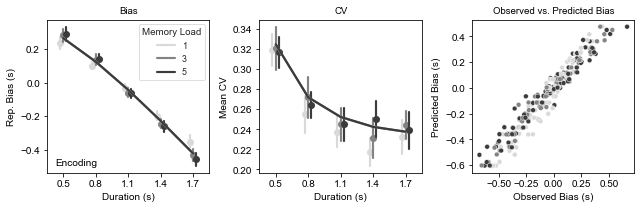

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.051,0.013,0.027,0.077,0.0,0.0,2330.0,2534.0,1.0
var_n[12],0.016,0.006,0.004,0.026,0.0,0.0,1114.0,1841.0,1.0
var_n[13],0.002,0.002,0.000,0.006,0.0,0.0,2652.0,2364.0,1.0
var_n[14],0.006,0.002,0.002,0.010,0.0,0.0,2894.0,3173.0,1.0


In [11]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
firstrun = False
if firstrun:
    encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, modelpath+'encoding')
    encoding_para
else:
    encoding_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'encoding_trace.nc')
    encoding_mdat = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_mdat.csv')
    encoding_para = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_para.csv')

plotModelPred(encoding_mdat, 'encoding')
az.summary(encoding_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [12]:
# calculate the correlation between mPred vs. repDur_mean using encoding_mdat
np.corrcoef(encoding_mdat['mPred'], encoding_mdat['repDur_mean'])

array([[1.        , 0.95496315],
       [0.95496315, 1.        ]])

In [13]:
np.corrcoef(encoding_mdat['repCV'], encoding_mdat['predCV'])

array([[1.        , 0.82522793],
       [0.82522793, 1.        ]])

In [27]:
modelpath

'NULL/'

## Memory Load on Reproduction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2753 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


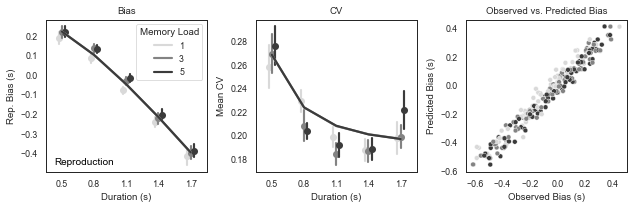

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.002,0.002,0.000,0.006,0.0,0.0,2126.0,2210.0,1.0
var_n[12],0.002,0.002,0.000,0.005,0.0,0.0,3089.0,3181.0,1.0
var_n[13],0.003,0.002,0.000,0.008,0.0,0.0,2799.0,2934.0,1.0
var_n[14],0.005,0.002,0.002,0.008,0.0,0.0,4436.0,3708.0,1.0


In [28]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']

firstrun = False
if firstrun:
    reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat = runModel(dat_reproduction, constrain, modelpath+'reproduction')
    reproduction_para
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_para.csv')
# plot the model prediction
plotModelPred(reproduction_mdat, 'reproduction')
az.summary(reproduction_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [29]:
np.corrcoef(reproduction_mdat['mPred'], reproduction_mdat['repDur_mean'])

array([[1.       , 0.9786673],
       [0.9786673, 1.       ]])

In [30]:
#correlation of CV
np.corrcoef(reproduction_mdat['repCV'], reproduction_mdat['predCV'])

array([[1.        , 0.69208618],
       [0.69208618, 1.        ]])

## Baseline Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3904 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


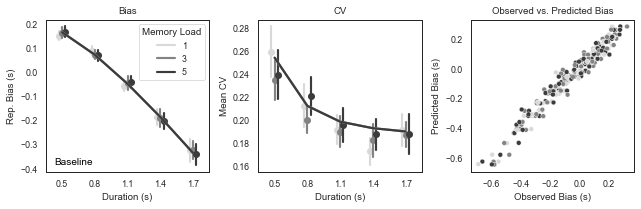

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.007,0.002,0.004,0.011,0.0,0.0,4618.0,3038.0,1.0
var_n[12],0.003,0.002,0.000,0.006,0.0,0.0,4540.0,3624.0,1.0
var_n[13],0.006,0.002,0.002,0.009,0.0,0.0,4421.0,3566.0,1.0
var_n[14],0.010,0.003,0.004,0.017,0.0,0.0,3801.0,3729.0,1.0


In [31]:
dat_baseline = expData[expData['ExpName'] == 'Baseline']
firstrun = False
if firstrun:
    baseline_trace, baseline_model, baseline_para, baseline_mdat = runModel(dat_baseline, constrain, modelpath + 'baseline')
    baseline_para
else:
	baseline_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'baseline_trace.nc')
	baseline_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_mdat.csv')
	baseline_para = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_para.csv')
plotModelPred(baseline_mdat, 'baseline')
az.summary(baseline_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [32]:
np.corrcoef(baseline_mdat['mPred'], baseline_mdat['repDur_mean'])

array([[1.        , 0.98826737],
       [0.98826737, 1.        ]])

In [33]:
#correlation of CV
np.corrcoef(baseline_mdat['repCV'], baseline_mdat['predCV'])

array([[1.       , 0.7551955],
       [0.7551955, 1.       ]])

## Memory Load on Encoding and Reproduction


In [34]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = False
if firstrun:
	both_trace, both_model, both_para, both_mdat = runModel(dat_both, constrain, modelpath +'both')
	both_para
else:
	both_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_para.csv')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7960 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


In [35]:
both_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_s_raw[0],0.365,0.294,-0.244,0.843,0.114,0.085,7.0,71.0,1.21
var_s_raw[1],-0.097,0.293,-0.646,0.358,0.149,0.114,4.0,65.0,1.43
var_s_raw[2],-0.264,1.291,-2.058,1.580,0.883,0.738,3.0,57.0,1.83
var_s_raw[3],-0.201,2.004,-2.842,2.552,1.384,1.161,3.0,48.0,1.83
var_s_raw[4],0.210,0.307,-0.402,0.738,0.133,0.100,5.0,67.0,1.28
...,...,...,...,...,...,...,...,...,...
t_s[11],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
t_s[12],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
t_s[13],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
t_s[14],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN


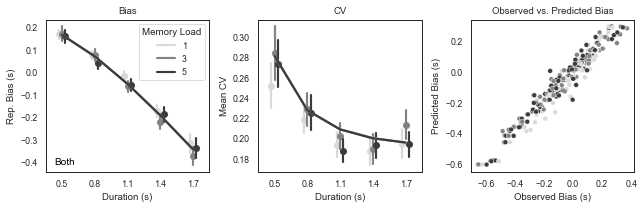

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.011,0.005,0.002,0.020,0.0,0.0,4160.0,3675.0,1.00
var_n[12],0.001,0.001,0.000,0.003,0.0,0.0,3151.0,3124.0,1.00
var_n[13],0.003,0.002,0.000,0.007,0.0,0.0,3848.0,3396.0,1.00
var_n[14],0.013,0.004,0.006,0.021,0.0,0.0,3579.0,3535.0,1.01


In [36]:
plotModelPred(both_mdat, 'both')
az.summary(both_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [37]:
np.corrcoef(both_mdat['mPred'], both_mdat['repDur_mean'])

array([[1.        , 0.98415312],
       [0.98415312, 1.        ]])

In [38]:
#correlation of CV
np.corrcoef(both_mdat['repCV'], both_mdat['predCV'])

array([[1.        , 0.77423749],
       [0.77423749, 1.        ]])

Plot for four experiments together

AttributeError: 'Legend' object has no attribute 'set_loc'

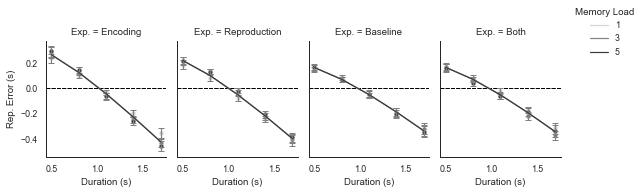

In [39]:
# combine encoding_mdat, reproduction_mdat, baseline_mdat, and both_mdat into mdat, but each data has additional column ExpName
encoding_mdat['Exp.'] = 'Encoding'
reproduction_mdat['Exp.'] = 'Reproduction'
baseline_mdat['Exp.'] = 'Baseline'
both_mdat['Exp.'] = 'Both'
exp_order = ['Encoding', 'Reproduction', 'Baseline', 'Both']
c_palette = ['lightgrey', '#838383',"#3b3b3b"] # consistent with R plot

mdat = pd.concat([encoding_mdat, reproduction_mdat, baseline_mdat, both_mdat], ignore_index=True)

# group and flatten the columns
mmdat = mdat.groupby(['curDur', 'WMSize', 'Exp.'], observed =True).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
									'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

# Create the FacetGrid, faceting on the ExpName column
g1 = sns.FacetGrid(mmdat, col="Exp.", hue="WMSize", height=2.5, aspect=0.8,col_order=exp_order, palette=c_palette)

# Map the scatter plot for reproduction error (repErr_mean)
g1.map(sns.scatterplot, 'curDur', 'repErr_mean')

# Add error bars to the scatter plots
def add_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=3, color='gray')

# Define a function to add the horizontal line at y=0
def add_hline(*args, **kwargs):
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Adds the horizontal line at y=0
# Add the horizontal line at y=0 to each subplot
g1.map(add_hline)

g1.map(add_error_bars, 'curDur', 'repErr_mean', 'repErr_sem')
# Map the line plot for predicted error (predErr_mean)
g1.map(sns.lineplot, 'curDur', 'predErr_mean')



# Customize the plot aesthetics
g1.set_axis_labels('Duration (s)', 'Rep. Error (s)')
# add legend on the top right corner
g1.add_legend(title='Memory Load')
# Adjust the legend position to the upper right corner of the entire plot
g1._legend.set_bbox_to_anchor((1, 0.9))  # Moves the legend to the upper right of the figure
g1._legend.set_loc('upper right')      # Aligns the legend to the upper right corner
# add label a to the top left corner of the first axis
g1.axes[0,0].text(0.01, 0.98, 'a', transform=g1.figure.transFigure, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
# save the figure to prediction_errors.png
plt.savefig(savefigpath+modelname+'_prediction_errors.png')
# Show the plot

plt.show()

In [ ]:

# Define a function to add the diagonal line
def add_diagonal(*args, **kwargs):
    ax = plt.gca()  # Get the current axis
    limits = [min(-0.6, -0.6), max(0.6, 0.6)]
    ax.plot(limits, limits, color='black', linestyle='--', linewidth=1)  # Draws the diagonal line

# now create the second pred. vs. obs. plot
# Create the FacetGrid, faceting on the ExpName column
g2 = sns.FacetGrid(mdat, col="Exp.", hue="WMSize", height=2.5, aspect=1,col_order=exp_order, palette=c_palette)
# Map the scatter plot for reproduction error (repErr_mean)
g2.map(sns.scatterplot, 'repErr', 'predErr')
# Add the diagonal line to each subplot
g2.map(add_diagonal)

# set x and y labels
g2.set_axis_labels('Observed Error (s)', 'Predicted Error (s)')
#g2.add_legend()
#g2._legend.set_title('Memory Load')
# add label a to the top left corner of the first axis
g2.axes[0,0].text(0.0, 0.98, 'b', transform=g2.fig.transFigure, fontsize=16, fontweight='bold', va='top')
# save the figure to predict_vs_obs.png
plt.savefig(savefigpath + 'predict_vs_obs.png')


## Memory load with Gap on Encoding and Reproduction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw, t_s]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5139 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


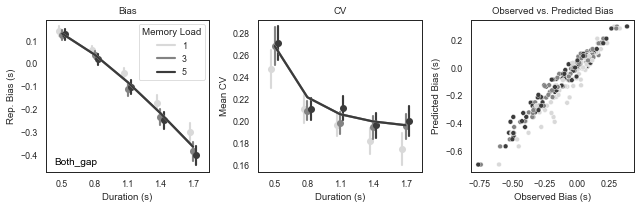

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.015,0.003,0.010,0.020,0.0,0.0,4341.0,2187.0,1.00
var_n[12],0.023,0.003,0.017,0.028,0.0,0.0,4686.0,2934.0,1.00
var_n[13],0.007,0.002,0.003,0.011,0.0,0.0,76.0,3056.0,1.02
var_n[14],0.004,0.001,0.002,0.005,0.0,0.0,4522.0,2556.0,1.00


In [14]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
firstrun = True
if firstrun:
	constrain = [0,0,0,1]
	both_gap_trace, both_gap_model, both_gap_para, both_gap_mdat = runModel(dat_gap, constrain, modelpath +'both_gap')
else:
	both_gap_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_gap_trace.nc')
	both_gap_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_mdat.csv')
	both_gap_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_para.csv')
plotModelPred(both_gap_mdat, 'both_gap')
az.summary(both_gap_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])	


In [ ]:
np.corrcoef(both_gap_mdat['mPred'], both_gap_mdat['repDur_mean'])

In [ ]:
#correlation of CV
np.corrcoef(both_gap_mdat['repCV'], both_gap_mdat['predCV'])

Note: Visual differences, $l_s$ was higher for Exp. 6a than others, while $k_r$ was close to zero for Exp. 6a. 

In [ ]:
def compute_subject_level_k_statistics(trace, k_param):
    """
    Computes the mean and standard deviation of parameter k_param for each subject
    from a PyMC InferenceData object (trace).

    Parameters:
    ----------
    trace : arviz.InferenceData
        The trace from the PyMC model containing posterior samples.
    k_param : str
        The name of the parameter (e.g., 'k_s', 'l_s', 't_s', 'k_r').

    Returns:
    -------
    k_mean : np.ndarray
        The posterior mean of the parameter for each subject.
    k_sd : np.ndarray
        The posterior standard deviation of the parameter for each subject.
    """

    # Check if parameter exists in the trace
    if k_param not in trace.posterior:
        raise ValueError(f"Parameter '{k_param}' not found in trace.posterior.")

    # Extract posterior samples for k_param: shape (nchains, ndraws, nsub)
    k_samples = trace.posterior[k_param].values

    # Flatten chains and draws -> shape (nchains * ndraws, nsub)
    k_samples_flat = k_samples.reshape(-1, k_samples.shape[-1])

    # Compute mean and standard deviation across posterior samples
    k_mean = np.mean(k_samples_flat, axis=0)
    k_sd = np.std(k_samples_flat, axis=0)

    return k_mean, k_sd

In [ ]:
#'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'

ks_encoding, ks_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_s')
ls_encoding, ls_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'l_s')
kr_encoding, kr_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_r')
ts_encoding, ts_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 't_s')
var_s_encoding, var_s_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_s')
mu_p_encoding, mu_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'mu_p')
var_p_encoding, var_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_p')
var_n_encoding, var_n_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_n')


ks_reproduction, ks_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_s')
ls_reproduction, ls_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'l_s')
kr_reproduction, kr_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_r')
ts_reproduction, ts_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 't_s')
var_s_reproduction, var_s_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_s')
mu_p_reproduction, mu_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'mu_p')
var_p_reproduction, var_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_p')
var_n_reproduction, var_n_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_n')

ks_both, ks_both_sd = compute_subject_level_k_statistics(both_trace, 'k_s')
ls_both, ls_both_sd = compute_subject_level_k_statistics(both_trace, 'l_s')
kr_both, kr_both_sd = compute_subject_level_k_statistics(both_trace, 'k_r')
ts_both, ts_both_sd = compute_subject_level_k_statistics(both_trace, 't_s')
var_s_both, var_s_both_sd = compute_subject_level_k_statistics(both_trace, 'var_s')
mu_p_both, mu_p_both_sd = compute_subject_level_k_statistics(both_trace, 'mu_p')
var_p_both, var_p_both_sd = compute_subject_level_k_statistics(both_trace, 'var_p')
var_n_both, var_n_both_sd = compute_subject_level_k_statistics(both_trace, 'var_n')

ks_both_gap, ks_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_s')
ls_both_gap, ls_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'l_s')
kr_both_gap, kr_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_r')
ts_both_gap, ts_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 't_s')
var_s_both_gap, var_s_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_s')
mu_p_both_gap, mu_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'mu_p')
var_p_both_gap, var_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_p')
var_n_both_gap, var_n_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_n')


ks_baseline, ks_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_s')
ls_baseline, ls_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'l_s')
kr_baseline, kr_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_r')
ts_baseline, ts_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 't_s')
var_s_baseline, var_s_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_s')
mu_p_baseline, mu_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'mu_p')
var_p_baseline, var_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_p')
var_n_baseline, var_n_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_n')


In [ ]:
# combine means together
para = [ks_encoding, ks_reproduction, ks_both, ks_both_gap, ks_baseline,
		ls_encoding, ls_reproduction, ls_both, ls_both_gap, ls_baseline,
		kr_encoding, kr_reproduction, kr_both, kr_both_gap, kr_baseline,
        ts_encoding, ts_reproduction, ts_both, ts_both_gap, ts_baseline,
		var_s_encoding, var_s_reproduction, var_s_both, var_s_both_gap, var_s_baseline,
		mu_p_encoding, mu_p_reproduction, mu_p_both, mu_p_both_gap, mu_p_baseline,
        var_p_encoding, var_p_reproduction, var_p_both, var_p_both_gap, var_p_baseline,
		var_n_encoding, var_n_reproduction, var_n_both, var_n_both_gap, var_n_baseline]
# reshape the array, each array has (16,)
para_r = np.stack(para, axis=0).reshape(-1, 80).T
# create a dataframe
df_para = pd.DataFrame(para_r, columns = ['ks','ls','kr', 'ts', 'var_s', 'mu_log', 'sigma_log', 'var_n'])

df_para['mu_p'] = np.exp(df_para['mu_log'] + 0.5 * df_para['sigma_log']**2)
df_para['var_p'] = np.sqrt((np.exp(df_para['sigma_log']**2) - 1) * np.exp(2*df_para['mu_log'] + df_para['sigma_log']**2))
df_para['Experiment'] = ['Encoding']*16 + ['Reproduction']*16 + ['Both']*16 + ['Both_gap']*16 + ['Baseline']*16
# delete mean prior and variance of prior in log scale
df_para = df_para.drop(columns=['mu_log', 'sigma_log'])

df_para.to_csv(OUTPUT_PATH + '/'+ modelname + '_ParaList.csv')
df_para.head()


In [ ]:
modelpath

In [ ]:
#plot mean and SEs of 'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n' as a function of Experiment
fig, ax = plt.subplots(2, 4, figsize=(9, 5))
fig.suptitle("Mean ± SE of Parameters by Experiment: " + modelpath, fontsize=14)

params = [
    ('ks', '$k_s$'),
    ('ls', '$l_s$'),
    ('kr', '$k_r$'),
    ('ts', '$t_s$'),
    ('var_s', '$var_s$'),
    ('mu_p', '$mu_p$'),
    ('var_p', '$var_p$'),
    ('var_n', '$var_n$')
]

# 循环绘制子图
for i, (param, title) in enumerate(params):
    row, col = divmod(i, 4)
    sns.barplot(
        data=df_para,
        x='Experiment',
        y=param,
        errorbar='se',
        ax=ax[row, col],
        color='gray'
    )
    ax[row, col].set_title(title)
    ax[row, col].set_ylabel('Mean')
    ax[row, col].set_xlabel('Experiment')
    ax[row, col].tick_params(axis='x', rotation=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(savefigpaht + 'Para_' + modelname + '.png', dpi=1200)
plt.show()


In [ ]:
# one-way anova test for k_s, factor is Experiment, with data df_para
import pingouin as pg
aov = pg.anova(data=df_para, dv='ks', between='Experiment', detailed=True)
aov

In [ ]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ks', between='Experiment', padjust='holm')
posthoc

In [ ]:
aov = pg.anova(data=df_para, dv='ls', between='Experiment', detailed=True)
aov

In [ ]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ls', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

In [ ]:
aov = pg.anova(data=df_para, dv='kr', between='Experiment', detailed=True)
aov

In [ ]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='kr', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)